<a href="https://colab.research.google.com/github/jaywanjohi/co-rise/blob/main/Juliet_Wanjohi_Week_1_PART_2_Sales_Regression_Modeling_QUESTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

# Week 1: Introduction to Regression

### Applying supervised machine learning in a practical setting
In this project, we will build supervised learning models to help make decisions in a business setting. We will focus on machine learning algorithms and development practices, so in this first project our dataset will be more of a "black box." 


Our project will walk through problem formulation, developing models, and evaluating model performance in the context of a business goal. Along the way, we will introduce the basics of formalizing supervised learning as a task, regression loss functions, and simple models for regression. You will build and test models using `scikit-learn` and supporting tools.

### Instructions

1. Before working on this task, you should complete the 1-D Regression notebook to get familiar with some basic concepts.
2. We provide starter code and data to give your work a common starting point and scaffolding. You must keep function signatures unchanged to support any later usage and to ensure correct grading of your project.
3. Ensure you read through the document and starting code before beginning your work. Understand the overall structure and goals of the project to make your implementation efficient. 


# Dependencies

Import all the necessary libraries we need throughout the project.

In [2]:
import pandas as pd
import numpy as np
from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from numpy.core.numeric import Inf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]

Set the random seed for NumPy so that we produce consistent results that can be easily discussed.

In [3]:
# Fix the random seed so that we get consistent results
np.random.seed(0)

# Regression modeling applied: Per-customer revenue prediction

**Scenario**: You've just been hired as a machine learning engineer at Snailsforce, the leader in direct mail marketing software. Your company's customers are businesses with a large range of yearly _customer spend_ which is driven by usage of the software. The revenue generated from each customer is closely related to usage and spend, so we will predict per-customer revenue as $y$.

Our high level goal is to increase overall revenue, and identify customers who might move up to our top tier services. The team has asked you to build a regression model to predict per-customer revenue. We believe that a model can identify statistical patterns in our historical data and these revenue estimates will provide actionable information for where to focus our customer support and sales efforts. 

You've been provided a dataset of historical account data including attributes of the customer, and their usage of the product. The goal is to use this historical data to estimate the total spend of a client for their next license year. 

Formalizing this task a bit, we will use customer usage attributes $x$ to predict _spend_, a normalized dollar amount for revenue, $y$. 

There is inherent randomness and unknown factors in the way we've framed this prediction task -- any range of unknown events could impact customers' usage. Thus, we will set realistic expectations for how to use this model. So long as the model can accurately predict future spend.

NOTE: We provide dataset values but give no information about the meaning of each customer attribute. In this project we will focus on ML techniques rather than using our intuitions about a task/dataset. In later projects we will use both, and work on challenging tasks where you can also inject domain knowledge to improve performance. 

## Data loading and basic checks

The dataset is stored on GDrive. This code downloads the dataset to your colab instance, then loads several matrices in a .npz file

In [4]:
# download dataset from public GDrive
!gdown --id 1o_duTLOfVaDHBWgMcq-ziywUJKWd-2WL

Downloading...
From: https://drive.google.com/uc?id=1o_duTLOfVaDHBWgMcq-ziywUJKWd-2WL
To: /content/proj_1_sales_dataset.npz
100% 135k/135k [00:00<00:00, 62.1MB/s]


In [5]:
with np.load('proj_1_sales_dataset.npz') as npdata:
  X_train = npdata['X_train']
  y_train = npdata['y_train']
  X_dev = npdata['X_dev']
  y_dev = npdata['y_dev']

In [6]:
print(npdata.files)

['X_train', 'X_dev', 'y_train', 'y_dev']


### Basic dataset information

Let's quickly check some statistics and basic facts about the dataset which are important for supervised learning. First, let's check the examples and features in our dataset. When working with data for ML tasks, we typically desire each variable to be 0 mean and standard deviation 1. For this project, we have already prepared the dataset to approximately match these values.

In [7]:
# Check range, min/max, mean, std, etc. for all input feature columns
pd.DataFrame(data=X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.033553,0.037349,-0.071254,0.016236,-0.060130,0.093037,-0.067582,0.068104,-0.055085,-0.053653,-0.061481,0.017692,-0.071632
std,0.954392,1.030878,0.998940,1.030643,0.992510,0.995166,1.012888,1.022526,0.969820,0.985496,1.013739,0.980342,0.988070
min,-0.733186,-0.841822,-1.603473,-0.545265,-1.491855,-3.817250,-2.369042,-1.353140,-1.167139,-1.568349,-2.771561,-3.943066,-1.620686
25%,-0.400898,-0.483615,-0.908631,-0.271902,-0.928456,-0.481834,-0.962185,-0.781176,-0.637914,-0.773947,-0.762626,0.192617,-0.864435
50%,-0.349878,-0.483615,-0.397200,-0.256833,-0.252491,-0.020076,0.257688,-0.208498,-0.511142,-0.465100,0.114232,0.366588,-0.289395
75%,-0.143746,0.318672,1.028326,-0.213755,0.568941,0.593891,0.845540,0.778044,-0.148702,0.223805,0.784476,0.448077,0.507380
max,9.323170,3.728990,2.496404,4.062429,2.798285,3.467186,1.290705,3.531645,1.916498,1.965037,1.689603,0.672469,3.482019


### Checking our output variable

For regression, we typically map a real-valued input vector to a real-valued scalar. This means the $(x, y)$ input/label pairs are a single value for y and a feature vector for x. Many of the techniques we discuss here extend to _multi-variate_ regression where $y$ is a vector. 

When working with a dataset, we typically want to understand the rough *distribution* of output variable $y$. First, let's plot the values of the output variable for our data. Again, we've already standardized the revenue values to have a mean of 0. 

{'boxes': [<matplotlib.lines.Line2D at 0x7f98684417d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f986844cad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9868453b10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f98684535d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9868441f50>,
  <matplotlib.lines.Line2D at 0x7f986844c5d0>]}

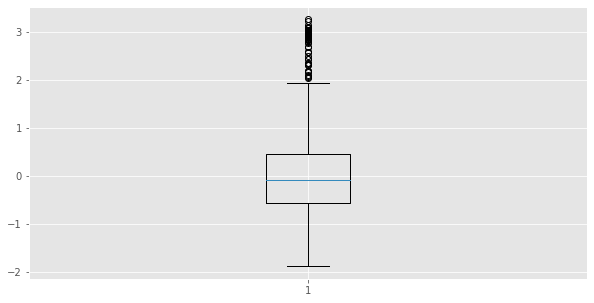

In [8]:
# scatterplot of y values with jitter
plt.boxplot(y_train)

## Iterative model development process: Regression

We have now loaded the dataset and performed some basic data checks. This data will provide the inputs for our ML experiments. Following our iterative development process, we will first establish starting characteristics for our model before trying to improve it. This approach ensures that we are clear about what we are measuring before spending time building and improving models. Here are our next steps towards building a quality model for this revenue prediction task:

Some setup steps:
1. Evaluation metric selection.
2. Split data into training / development sets. 
3. Establish code/procedure to evaluate model predictions.
4. Build and evaluate simple baselines. 

Iterative hypothesis-driven modeling improvements:
1. Build and evaluate a first regression model on the data.
2. Diagnose next steps for how to improve model.
3. Propose hypothesis for how to improve model and iterate!

Let's go!

### Evaluation metric selection

Our task is regression, and we are predicting account values in dollars. When working with regression, we typically default to mean squared error (MSE) as a guiding metric because it works well with many regression models. However, it's useful to consider multiple loss functions so that we can choose an option that optimizes the problem we need to solve.

Our goal is to predict customer revenue. Because MSE is sensitive to large values, MSE risks putting too much weight on outlier errors when comparing models. Let's introduce additional metrics to give a different view on performance with less sensitivity to outliers

Mean absolute error (MAE) = 
$\frac{1}{n} \sum_{i=0}^n |y^{(i)}-\hat{y}^{(i)}|$

MAE is the average of the absolute values of errors. MAE is often the best single diagnostic for comparing regression model performance because it is easier to interpret and less sensitive to outliers compared to MSE.

Mean percentage error (MPE) = 
$\frac{1}{n} \sum_{i=0}^n \frac{(y^{(i)}-\hat{y}^{(i)})}{y^{(i)}} $

MPE gives us a percentage error which is not affected by larger/smaller values of $y$, only the relative correctness of the prediction $\hat{y}$. Another useful property of MPE is that errors have a positive or negative sign depending on whether the model under-estimates $y$ (positive error) or over-estimates (negative error). This means that MPE will give us an aggregate view of whether a model tends to predict too much or too little.

For now, we are assuming that predicting revenue enables us to make decisions. These simple regression metrics are closely tied to evaluating how well our regression model predicts these values. Once we have a high quality regression model we will revisit how we use the model in the context of our business needs.

For quick intuition about MSE, MAE, MPE, and some additional regression metrics, see https://www.dataquest.io/blog/understanding-regression-error-metrics/



### Split data into training / development sets

Now, we reserve part of the data as a development set to keep fixed during our work. To make comparison of results easy, we have already provided a training/development split in the data you loaded.

We assume that our dataset examples are _independent and identically distributed ([i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables))_ Basically, this means we assume that each example is an independent dice roll from the same die. This assumption means we can randomly select a development set from our full data, and consider it a representative sample. 

Beware of the i.i.d. assumption when working in machine learning. Data distributions in the real world can _shift_ from unseen events the data does not measure (e.g. shipping problems during COVID). Distribution shift means the indentically distributed assumption breaks, and our model evaluations might not be a good proxy for real-world performance. Revenue prediction models used during COVID pandemic would have experienced such shift in the incoming data compared to historical training data, likely resulting in model inaccuracy. 

Depending on the domain, it might be necessary to split data by time, or by person to ensure development set instances are not overly correlated with training instances. In our revenue prediction setting, we will ultimately test our model by making predictions on future account behavior and observing the results over time.

### Establish code/procedure to evaluate model predictions


To ensure we measure and compare models in a consistent way, we will create shared code that we use to evaluate all models. Creating and validating this code with a simple baseline before building models gives us a controlled way to test and debug our metrics code before introducing the additional uncertainty of model results.

#### **Task: Implement an evaluation function**

Define a function to compute and return MSE, MAE, and MPE using the provided function signature. You may use `sklearn.metrics` functions to compute error terms.

In [9]:
def compute_eval(actual: np.ndarray, pred: np.ndarray ) -> Tuple[float, float, float]:
  """Computes evaluation metrics on given predicted/actual values
  Args:
    actual: 1-D array of actual values
    pred: 1-D array of predicted values

  Returns:
    Mean squared error (float),
    Mean absolute error (float),
    Mean percentage error (float)
  
  """
  
  #############################
  #### YOUR CODE GOES HERE ####
  mse_val = mean_squared_error(actual, pred)
  mae_val = mean_absolute_error(actual, pred)
  mpe_val = mean_absolute_percentage_error(actual, pred)

  return (mse_val, mae_val, mpe_val)
  
  #############################   



Now let's quickly check our evaluation function using some basic inputs. Think of this as a small software _[unit test](https://en.wikipedia.org/wiki/Unit_testing)_.

In [10]:
n_samples_test = 100
print("Expect some error (MSE 2.25 MAE 1.5 MPE 1.0)")
print("Computed error: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(1.5 * np.ones(n_samples_test), np.zeros(n_samples_test)))
print("Expect 0 error")
print("Computed error: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(np.ones(n_samples_test), np.ones(n_samples_test)))

Expect some error (MSE 2.25 MAE 1.5 MPE 1.0)
Computed error: MSE: 2.25  MAE: 1.50  MPE: 1.00 
Expect 0 error
Computed error: MSE: 0.00  MAE: 0.00  MPE: 0.00 


### Build and evaluate simple baselines


With our metrics function validated, let's establish some simple baselines on our actual dataset. These baselines are useful for establishing a lower bound on performance -- a model capturing useful patterns in the data should outperform predicting the average output value for all examples. If models are unable to outperform these baselines, we would expect bugs in our code or issues in the dataset preventing useful learning.

#### **Task: Predict the average value** 

Compute the mean (average) output ($y$) value on the training set. Use this value as a prediction for each test example. Report results using your evaluation function.

In [11]:
#############################
#### YOUR CODE GOES HERE ####

avg_val = np.mean(y_train)
pred = np.full((200,), avg_val)
print("Computed error: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_dev, pred))
############################# 

Computed error: MSE: 1.16  MAE: 0.77  MPE: 3.57 


## Hypothesis-driven model development

Machine learning system development has some inherent uncertainties. To better navigate the many options, we will focus on keeping a driving _hypothesis_ to justify what actions we take to improve the ML system. Additionally, we will often need different diagnostics or debugging tricks to gain information about what to try next.

As a first step, let's establish a baseline using a simple, robust technique -- linear regression!

### Build and evaluate a first regression model on the data


With baselines and evaluation established, it's time to begin building models. Typically we start with a simpler, easier to understand model. Based on performance of this initial model we will make decisions about whether to try more complex models on this dataset. Linear regression is a reliable first choice as it is a well-stuidied model, relatively easy to interpret, and has many extensions we can use to improve performance in different situations. 

#### **Task: Build and evaluate a linear regression model.**

Fit a `LinearRegression` model on the training set. Report evaluation results on both the training and development sets by calling your `compute_eval` function.

In [12]:
## initialize empty model
regr_lin = linear_model.LinearRegression()

#############################

# Train the regression model  
#### YOUR CODE GOES HERE ####
regr_lin.fit(X_train, y_train)
pred_y_train = regr_lin.predict(X_train)

regr_lin.fit(X_dev, y_dev)
pred_y_dev = regr_lin.predict(X_dev)
# Report both the training and development set eval
print("Computed error for training set: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_train, pred_y_train))

print("Computed error for dev set: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_dev, pred_y_dev))
############################# 

Computed error for training set: MSE: 0.25  MAE: 0.36  MPE: 2.01 
Computed error for dev set: MSE: 0.19  MAE: 0.33  MPE: 3.27 


### Use diagnostics to create a hypothesis for how to improve (and iterate!)

So far we've performed an initial model building process to obtain baseline results in a sensible way. This process is fairly straightforward, but after fitting an initial model, we have many possible paths for what we might try next.

Let's consider some diagnostic questions to determine the most promising next action to try:
1. Is this model "good enough"? Does current dev set performance meet our goal for this system?
2. Is the model improving compared with simple baselines on both the training and dev sets?
3. Is training set performance at/above goal performance for this system? Is training set performance saturated near zero error?
4. How do training set and dev set results compare with each other? 

Think about your response to each question above. Next we will use these diagnostics to decide a next action. Here are reasonable responses to the questions above:   
1. _No. Our teams estimate a model needs dev set performance MSE < 0.2 to meaningfully guide actions._
1. _Yes. The model clearly outperforms our simple baselines, indicating the model learned some statistical patterns on the training set which were useful in making correct predictions on the dev set_
1. _Training set performance is far from zero error, and does model does not appear to be fitting training set perfectly._ 
1. _Training set performance very close to dev set performance, and not meeting overall performance goals._


For supervised learning problems large or small, there are a few key concepts we use to interpret our diagnostics:

* **Model bias** is the assumptions or representational choices in our model. A high bias model (stronger assumptions in the model) makes consistent predictions. However, high bias assumptions might cause dev set errors or miss useful patterns in the training set.

* **Model variance** is the ability of the model to fit small fluctuations in training data. High variance models accurately capture patterns in the training set, but might find spurious correlations. Models can make errors on new data when predictions are influenced by noise or spurious correlations in the training set.

* **Dataset irreducible error** focuses on issues in the training and test datasets which impose a limit on how accurate the predictions any model can be. Sources of this error might be noise in input/output variables, unobserved information (missing input variables), or even data shift over time.

We will explore these concepts in more depth later in the course. For now, let's revisit our diagnostic question responses in the context of these concepts.

**Diagnosis**

Based on our question responses, we might suspect the model is _high bias_ and _low variance_. We conclude this because the model has significant training set error and dev set errors are closely matched. We also use the term _under-fitting_ to describe a model which performs poorly on the dev set and does not fit the training data as well as we hope.

Finally, we have no reason to suspect dataset irreducible error issues yet. An inability to fit the training set might also stem from dataset noise or errors, but we believe the data is sensible and well prepared, so we can focus on improving the model for now.

### Propose hypothesis for how to improve performance

With our _high bias, low variance, under-fitting_ diagnosis, we can form a hypothesis about how to improve performance. When our model is high bias relative to the task, typically we want to find ways to build a _more expressive model_. In the case of linear regression, the linear assumption of the model might be too simple to fit the training data and capture useful patterns for this problem.

We hypothesize a more expressive model will better fit the training set, and this improved performance will generalize to the dev set. So we want to try building higher variance models.

Let's test this hypothesis by doing a next iteration of our modeling development process with more expressive, nonlinear models. 

## Iterating on model improvements: Nonlinear models

Let's work on the "inner loop" of iterative model improvement. We have clear baselines, metrics, and our goal is to find a nonlinear model which improves upon current performance. 

For rapid model improvement, we value the ability to try many modeling ideas quickly. Let's establish a baseline model, and then quickly try out many extensions.

### Iterative model improvement

As in our simple regression dataset experiments, we can try `KNeighborsRegressor` as a nonlinear model with more _variance_ than our linear model.




#### **Task: Build a K nearest neighbors model.**

Let's try a new nonlinear modeling approach with `KNeighborsRegressor`. Nearest neighbors can be used for both classification and regression. The basic idea is to keep your training set as a lookup table, and making new predictions by checking the $k$-nearest training points to compute a prediction. Here the choice of how many neighbors to use ($k$) is a _hyperparameter_ of our model. We use "hyper" because such model options are one level up from the standard model parameters we find from training data using `.fit()`.

Fit a `KNeighborsRegressor` model and report evaluation results on the training and development sets using `compute_eval()`. Adjust model hyperparameter `n_neighbors` ($k$) to find the best dev set performance you can. 

**Extension**: If you're already familiar with the basics of using a nearest neighbors model, try exploring more hyperparameters to improve performance. Refer to [scikit documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) to see options like the distance metric, and use course readings to get a deeper mathematical understanding of how these hyperparameters affect the model. 

In [13]:
## initialize empty model
regr_kn = KNeighborsRegressor(n_neighbors=2)
# you may initialize a new model to change settings

#############################
#### YOUR CODE GOES HERE ####
  
# Train the regressor model
regr_kn.fit(X_train, y_train)
pred_y_train = regr_kn.predict(X_train)

regr_kn.fit(X_dev, y_dev)
pred_y_dev = regr_kn.predict(X_dev)
# Report the training and test set eval


############################# 

# Report both the training and development set eval
print("Computed error for training set: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_train, pred_y_train))

print("Computed error for dev set: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_dev, pred_y_dev))

Computed error for training set: MSE: 0.01  MAE: 0.06  MPE: 0.38 
Computed error for dev set: MSE: 0.01  MAE: 0.07  MPE: 2.48 


To find good settings for your nearest neighbors model, you likely ran multiple iterations of fitting the model and evaluating results. Now, let's _search_ the space of possible models in a more principled way. We often frame the problem of ML model development as searching for the best model out of infinitely many possibilities. 

It's okay if your nearest neighbors model is worse than the linear baseline -- this can happen when the assumptions of a particular model are not a good match for a dataset or task. Below we will introduce some additional nonlinear models you can try. 

#### **Task: Model selection helper function**

Using the function signature provided, implement a function which takes a list of models along with training and test data. Fit each model and then evaluate them on both training and dev sets. Your function should return a list of training and dev metric tuples corresponding to the model list input. This helper function allows us to quickly evaluate a set of candidate models as we search for the best model.

In [109]:
def search_models_helper(model_list: list, X_tr: np.ndarray, y_tr: np.ndarray, 
                        X_dev: np.ndarray, y_dev: np.ndarray) -> Tuple[list, list, int]:
  """Evaluate each model in model_list
  Args:
    model_list: 1-D array of scikit models to train with .fit()
    X_tr: 2-D array of training set inputs
    y_tr: 1-D array of training set labels
    X_tr: 2-D array of dev set inputs
    y_tr: 1-D array of dev set labels

  Returns: Tuple() of:
    dev_metrics_list: List of tuples for dev set metrics. Same order as model_list
    train_metrics_list: List of tuples for training set metrics. Same order as model_list
    best_mse_index: int model_list index of lowest dev set MSE model
  """
  
  #############################
  #### YOUR CODE GOES HERE ####

  train_metrics_list = []
  dev_metrics_list = []
  best_mse_index = 0

  for model in model_list:
    model.fit(X_tr, y_tr)
    pred_y_train = model.predict(X_tr)
    train_metrics_list.append(compute_eval(y_train, pred_y_train))

    model.fit(X_dev, y_dev)
    pred_y_dev = model.predict(X_dev)
    dev_metrics_list.append(compute_eval(y_dev, pred_y_dev))
  
  best_mse_index = dev_metrics_list.index(min(dev_metrics_list, key = lambda t:t[0]))
  return (dev_metrics_list, train_metrics_list, best_mse_index)

  ############################# 

#### **Extension: Try advanced nonlinear algorithms**

Nearest neighbors is an intuitive ML algorithm since predictions are based on values from the training set near a query point. You are welcome to experiment with other nonlinear regression modeling approaches to improve performance. 

Below are some additional modeling approaches that you can try, but you might need to understand more about how the models work to achieve good results. 

In [110]:
#############################
#### **OPTIONAL** YOUR CODE GOES HERE ####

#############################

# Random forest
# Try adjusting n_estimators and max_leaf_nodes
from sklearn.ensemble import RandomForestRegressor
rand_forest_reg = RandomForestRegressor(n_estimators=30, max_leaf_nodes=10)

# Train the RandomForestRegressor model
rand_forest_reg.fit(X_train, y_train)
pred_y_train = rand_forest_reg.predict(X_train)

rand_forest_reg.fit(X_dev, y_dev)
pred_y_dev = rand_forest_reg.predict(X_dev)

# Report both the training and development set eval
print("Computed error for training set - RandomForestRegressor : MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_train, pred_y_train))

print("Computed error for dev set - RandomForestRegressor : MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_dev, pred_y_dev))

# Gradient boosting regressor
# Try adjusting n_estimators and max_leaf_nodes
from sklearn.ensemble import GradientBoostingRegressor
grad_boost_reg = GradientBoostingRegressor(n_estimators=30, max_leaf_nodes=10)

# Train the RandomForestRegressor model
grad_boost_reg.fit(X_train, y_train)
pred_y_train = grad_boost_reg.predict(X_train)

grad_boost_reg.fit(X_dev, y_dev)
pred_y_dev = grad_boost_reg.predict(X_dev)

# Report both the training and development set eval
print("Computed error for training set - GradientBoostingRegressor : MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_train, pred_y_train))

print("Computed error for dev set - GradientBoostingRegressor : MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_dev, pred_y_dev))

# Multi-layer perceptron (Simple neural network)
# Try adjusting hidden_layer_sizes
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor(hidden_layer_sizes=(1000, ))

# Train the RandomForestRegressor model
mlp_reg.fit(X_train, y_train)
pred_y_train = mlp_reg.predict(X_train)

mlp_reg.fit(X_dev, y_dev)
pred_y_dev = mlp_reg.predict(X_dev)

# Report both the training and development set eval
print("Computed error for training set - MLPRegressor : MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_train, pred_y_train))

print("Computed error for dev set - MLPRegressor : MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_dev, pred_y_dev))



Computed error for training set - RandomForestRegressor : MSE: 0.13  MAE: 0.27  MPE: 2.01 
Computed error for dev set - RandomForestRegressor : MSE: 0.07  MAE: 0.21  MPE: 4.71 
Computed error for training set - GradientBoostingRegressor : MSE: 0.07  MAE: 0.21  MPE: 1.20 
Computed error for dev set - GradientBoostingRegressor : MSE: 0.04  MAE: 0.16  MPE: 3.58 


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:641: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  intercept_grads,


Computed error for training set - MLPRegressor : MSE: 0.02  MAE: 0.10  MPE: 0.59 
Computed error for dev set - MLPRegressor : MSE: 0.02  MAE: 0.11  MPE: 4.91 


#### **Task: Search over hyperparameters to improve performance**

Now let's use the search helper function to try several nonlinear models in a more efficient way. Create a list of nonlinear models and use your `search_models_helper()` function to find the model which produces the lowest dev set MSE. You can explore different hyperparameter settings of the same model (e.g. `n_neighbors`), or different types of nonlinear models. 

**Extension** For more depth, try defining your list of potential models using a principled hyperparameter search technique. For example, randomly sample from a distribution of possible parameters, _grid search_ over different combinations of hyperparameter settings, or use a hyperparameter optimization algorithm like [hyperopt](http://hyperopt.github.io/hyperopt/).



In [121]:
from numpy.random.mtrand import beta
model_list = []
#############################
#### YOUR CODE GOES HERE ####

# Create model list by trying different n_neighbors settings
regr_kn_2 = KNeighborsRegressor(n_neighbors=2)
regr_kn_4 = KNeighborsRegressor(n_neighbors=4)
regr_kn_6 = KNeighborsRegressor(n_neighbors=6)

model_list.append(regr_kn_2)
model_list.append(regr_kn_4)
model_list.append(regr_kn_6)

(dev_metrics_list, train_metrics_list, best_mse_index) = search_models_helper(model_list, X_train, y_train, X_dev, y_dev)
print("Best Model %s with MSE val %.2f" % (model_list[best_mse_index], dev_metrics_list[best_mse_index][0]))

############################# 

Best Model KNeighborsRegressor(n_neighbors=2) with MSE val 0.01


**Question**:

Report the lowest dev MSE you found and describe the model settings which produced it.

Lowest dev MSE is 0.01 for the model KNeighborsRegressor with n_neighbors = 2

Describe how you chose the list of models to try. 

I explored different hyperparameter settings of the same model by trying out different n_neighbors

===== (Write your answer here) ======

Next, create a plot to show the comparative MSE performance for the models you tried. Choose your best model, ensure you fit it to the training set, and store it in `regr_nl_best`. 

We will revisit our current ML development hypothesis and diagnostic questions using the model you built.

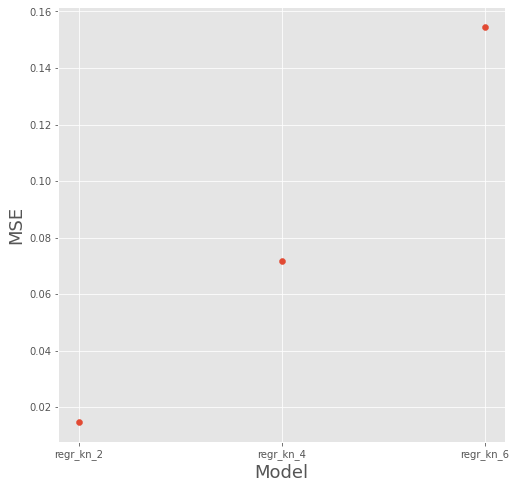

KNeighborsRegressor(n_neighbors=2)

In [112]:
regr_nl_best = None
#############################
#### YOUR CODE GOES HERE ####
model_str_list = ["regr_kn_2", "regr_kn_4", "regr_kn_6"]

mse_val_list = []
for metrics_tuple in dev_metrics_list:
  mse_val_list.append(metrics_tuple[0])

plt.figure(figsize=(8, 8))
plt.scatter(model_str_list, mse_val_list)
plt.xlabel('Model', fontsize=18)
plt.ylabel('MSE', fontsize=18)
plt.show()

regr_nl_best = KNeighborsRegressor(n_neighbors=2)
regr_nl_best.fit(X_train, y_train)

#############################

## Diagnose next steps after nonlinear modeling improvements

After iterating on nonlinear modeling improvements, let's compare results of the best nonlinear model you found with our initial linear model from earlier.

In [113]:
print("Linear model:: ")
print("Training set error: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(regr_lin.predict(X_train), y_train))

print("Dev set error: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(regr_lin.predict(X_dev), y_dev))

print("Best nonlinear model:: ")
print("Training set error: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(regr_nl_best.predict(X_train), y_train))

print("Dev set error: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(regr_nl_best.predict(X_dev), y_dev))


Linear model:: 
Training set error: MSE: 0.32  MAE: 0.39  MPE: 24.86 
Dev set error: MSE: 0.19  MAE: 0.33  MPE: 1.38 
Best nonlinear model:: 
Training set error: MSE: 0.01  MAE: 0.06  MPE: 0.40 
Dev set error: MSE: 0.32  MAE: 0.39  MPE: 5.62 


Recall our hypothesis _a more expressive model will better fit the training set, and this improved performance will generalize to the dev set._ Were you able to find a nonlinear model which outperforms our linear baseline?

*In terms of the training set, the non-linear model outperformed the linear model, but it did not generaize as well to the dev set as the linear model.*

Some additional plotting and diagnostics can help us compare performance between models. 
First we can check the _predicted_ vs _actual_ values for $y$ for both models. 

This scatter plot shows us where model predictions disagree with ground truth, perfect predictions are along the diagonal line $y=x$. This plot helps us check for patterns of errors. We also plot the two models' predictions against each other to look for agreement.

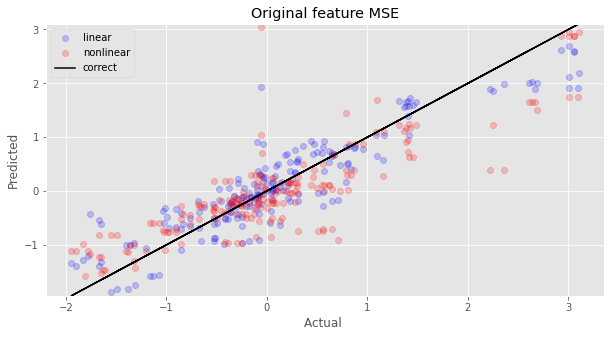

In [114]:
plt.plot(y_dev, regr_lin.predict(X_dev), 'bo', alpha=0.2, label='linear')
plt.plot(y_dev, regr_nl_best.predict(X_dev), 'ro', alpha=0.2, label='nonlinear')
plt.plot(y_dev, y_dev, 'k-', label='correct')
plt.ylim(np.min(y_dev), np.max(y_dev))
plt.xlabel("Actual ")
plt.ylabel("Predicted")
plt.title('Original feature MSE')
plt.legend()
plt.show()

To more directly understand where predictions differ, we can construct a similar plot using the linear model's predictions as $x$ axis, and your nonlinear model's predictions as $y$ axis. This plot helps us investigate the question, _"How do predictions from the nonlinear model deviate from linear model predictions?_" 

* Note this does not say whether either model is more correct, just where the predictions differ. 
* The line $y=x$ in this plot is where both models predict the same value for a dev set example.
* Points above the line $y=x$ indicate the nonlinear model predicting a larger value compared with the linear model. 
* This diagnostic can help us check for unusual bias or outliers in a more complex model. This helps guide decisions about which model to use in a production system.


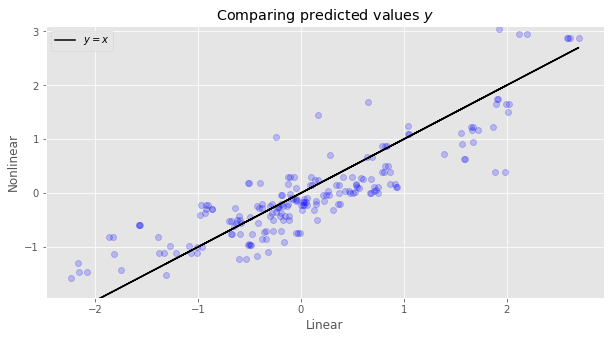

In [115]:
plt.plot(regr_lin.predict(X_dev), regr_nl_best.predict(X_dev), 'bo', alpha=0.2)

plt.plot(regr_lin.predict(X_dev), regr_lin.predict(X_dev), 'k-', label='$y=x$')
plt.ylim(np.min(y_dev), np.max(y_dev))
plt.xlabel("Linear")
plt.ylabel("Nonlinear")
plt.title('Comparing predicted values $y$')
plt.legend()
plt.show()

**Question**:

Using error metrics for both models along with the plots we've just created, which model would you prefer when predicting future revenue of accounts? 

Think about what types of decisions this model will help make, and how model errors might impact the eventual marketing/sales team actions influenced by this model. Some considerations:

* We prefer being more accurate for larger accounts, as this is more valuable for the company overall
* Does either model exhibit a pattern of errors with consistent bias of over/under-estimating?
* How do models perform on outlier values where the true value is at the extreme large/small ranges for $y$?


(Write your answer here)

Which model would you prefer when predicting future revenue of accounts?
I would use the non-linear model because it has an MSE val on the dev set that can be improved through further hyper-parameter optimization in order to have better/more accurate predictions on new data. 

Does either model exhibit a pattern of errors with consistent bias of over/under-estimating?
The linear model is underfitting - has poor performance on training and poor generalization on the dev set, whereas the non-linear model is overfitting - has good performance on the training but poor generalization to the dev set.

How do models perform on outlier values where the true value is at the extreme large/small ranges for  𝑦 ?

The non-linear model has more outliers in terms of predictions than the linear model whose values are closer to the y=x straight line/correct values.




## Improving a linear model with derived features

We hypothesized our linear model is high bias, low variance and under-fitting the training data. We tried different prediction algorithms (nearest neighbors, decision trees, etc.) to build nonlinear models with lower bias. We might also improve a high bias model by introducing _new input features_. 

We create a new input feature vector $\tilde{x} = [x, x_{new}]$ which includes our original features $x$ as well as new features $x_{new}$. Adding new input features often happens as we add new information to improve predictions when _under-fitting_.

Rather than expanding $x$ with new information about the task, for now we will make our linear model more expressive by expanding $x$ with _derived features_.
Our new input features will be nonlinear transformations of the existing $x$. Scikit provides a simple _transform_ mechanism which produces new input features $\tilde{x}$ for all examples.

In [116]:
# perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree=3)
X_train_trans = trans.fit_transform(X_train)
X_dev_trans = trans.fit_transform(X_dev)

A degree 2 polynomial transform means if we had original input features $x=[a, b]$, the derived input features are $\tilde{x} = [1, a, b, a^2, ab, b^2]$. We can extend this to any polynomial order >= 2, but this can quickly grow the number of features too large for easy use. 


Recall a linear model takes the form $y = \theta_1 x_1 + \theta_2 x_2 ...$ so applying a linear model to our derived features allows us to model some nonlinear variation in our original input data because we now have a _linear_ model applied to _nonlinear_ derived features of the data.

#### **Task: Evaluate and compare a linear model with derived features**

Fit and evaluate a linear regression model on the transformed training and test sets just created.

In [117]:
# fit an evaluate a linear model on the transformed features
regr_poly_lin = linear_model.LinearRegression()

#############################
  #### YOUR CODE GOES HERE ####
regr_poly_lin.fit(X_train_trans, y_train)
pred_y_train = regr_poly_lin.predict(X_train_trans)


regr_poly_lin.fit(X_dev_trans, y_dev)
pred_y_dev = regr_poly_lin.predict(X_dev_trans)
# Report the training and test set eval


############################# 

# Report both the training and development set eval
print("Computed error for training set: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_train, pred_y_train))

print("Computed error for dev set: MSE: %.2f  MAE: %.2f  MPE: %.2f " 
      % compute_eval(y_dev, pred_y_dev))
############################# 

Computed error for training set: MSE: 0.02  MAE: 0.09  MPE: 0.63 
Computed error for dev set: MSE: 0.00  MAE: 0.00  MPE: 0.00 


The expanded features model has _lower bias_ and _higher variance_ compared to the model with original features. We conclude this because the new model has more free parameters ($\theta$), and can model some nonlinear relations in the data via the derived features. 

Some observations on linear model performance on the expanded feature set:
* Training set error: Expanded feature model achieves almost 0 error
* Dev set error: Derived feature model achieves lower dev error than original features model
* With 0 training error, we should check for _overfitting_ in our derived feature model. Overfitting happens when fitting variations in the training set harms dev set performance by the model finding coincidences in the training set. 

## Regularization

The linear model using derived features is fitting the training set perfectly and could be over-fitting. _Regularization_ introduces a penalty for model complexity when fitting/training the model. By introducing such a penalty, regularization provides a way to trade off model complexity (variance) with how well a model generalizes to perform well on dev set examples. 

In general, regularization is typically a term we add to the loss function so that our final model will be influenced by the regularization penalty and our original objective/loss function. We now think of our overall loss function $\mathcal{L}_{\mathcal{D}}^{tot}$ as the sum of our original loss function and a new loss term $\mathcal{L}_{\mathcal{D}}^{reg}$,

$\mathcal{L}_{\mathcal{D}}^{tot} (f_\theta(x)) = 
\mathcal{L}_{\mathcal{D}}^{fit} (f_\theta(x))
+ \alpha \mathcal{L}_{\mathcal{D}}^{reg} (\theta)$.

The parameter $\alpha$ allows us to adjust the trade-off between the two terms. Directly controlling this tradeoff allows us to penalize the complexity of an over-fitting model and hopefully improve dev set performance by preventing the model from fitting unhelpful relationships in the training set.

An often used, simple regularization approach is sum of squared values of the model parameters $\theta$,

$\mathcal{L}_{\mathcal{D}}^{reg} (\theta) = \alpha \sum_j \theta_j^2$

This sum of squares regularization is also called $L_2$ since it corresponds to the $L_2$ norm of the vector $\theta$.

Finally, let's see our full linear regression loss with $L_2$ regularization,

$\mathcal{L}_{\mathcal{D}} (f_\theta(x)) = \sum_{i \in \mathcal{D}} (\hat{y}^{(i)} - y^{(i)})^2 +
\alpha \sum_j \theta_j^2$

This regression and regularization combination is well-studied and widely used. In fact, it has a special name, ridge regression.


### **Task: Linear regression with regularization**

Using the `Ridge` model and your `search_models_helper()` function, try several settings for the regularization parameter $\alpha$. Report training and dev set metrics for the best model you find for *both* the expanded features and original datasets. 

Fit and store the best model for each feature set.

Hint: use yourto find a good setting for $\alpha$. Report the training and dev set metrics for y

In [122]:
from sklearn.linear_model import Ridge
# try at least these values but you can add more
alpha_list = [0, 1, 10, 100, 1000, 10000]
## store your lowest MSE model for each feature set in the variable names below
regr_ridge_orig = None
regr_ridge_poly = None
model_list = []

#############################
#### YOUR CODE GOES HERE ####

# Create model list by trying different alpha settings
for alpha in alpha_list:
  model_list.append(Ridge(alpha=alpha))

## original feature set

# fit model with best settings

dev_metrics_list, train_metrics_list, best_mse_index = search_models_helper(model_list, X_train, y_train, X_dev, y_dev)
regr_ridge_orig = model_list[best_mse_index]
print("Best Model Original Train Set %s with MSE val %.2f" % (regr_ridge_orig, train_metrics_list[best_mse_index][0]))
print("Best Model Original Dev Set %s with MSE val %.2f" % (regr_ridge_orig, dev_metrics_list[best_mse_index][0]))
for i in range(len(alpha_list)):
  print("Ridge Original Metrics Train Set %s for alpha: %i" % (train_metrics_list[i], alpha_list[i]))
  print("Ridge Original Metrics Dev Set %s for alpha: %i" % (dev_metrics_list[i], alpha_list[i]))

## transformed feature set

# fit model with best settings

dev_metrics_list, train_metrics_list, best_mse_index = search_models_helper(model_list, X_train_trans, y_train, X_dev_trans, y_dev)
regr_ridge_poly = model_list[best_mse_index]
print("Best Model Transformed Train Set %s with MSE val %.2f" % (regr_ridge_poly, train_metrics_list[best_mse_index][0]))
print("Best Model Transformed Dev Set %s with MSE val %.2f" % (regr_ridge_poly, dev_metrics_list[best_mse_index][0]))
for i in range(len(alpha_list)):
  print("Ridge Transformed Metrics Train Set %s for alpha: %i" % (train_metrics_list[i], alpha_list[i]))
  print("Ridge Transformed Metrics Dev Set %s for alpha: %i" % (dev_metrics_list[i], alpha_list[i]))

############################# 

Best Model Original Train Set Ridge(alpha=0) with MSE val 0.25
Best Model Original Dev Set Ridge(alpha=0) with MSE val 0.19
Ridge Original Metrics Train Set (0.2453863975331144, 0.3604477731232749, 2.0104906769091735) for alpha: 0
Ridge Original Metrics Dev Set (0.1933268988039723, 0.3345418921876317, 3.2699964990560613) for alpha: 0
Ridge Original Metrics Train Set (0.24538873958305776, 0.36023793998760223, 2.0077555547576647) for alpha: 1
Ridge Original Metrics Dev Set (0.1933713917498067, 0.3348756206410528, 3.444695647842483) for alpha: 1
Ridge Original Metrics Train Set (0.24558487372707768, 0.35862235428321215, 1.9849548910901815) for alpha: 10
Ridge Original Metrics Dev Set (0.19593097539463267, 0.339763830472825, 4.411003854482659) for alpha: 10
Ridge Original Metrics Train Set (0.2532751137150015, 0.3546278717653647, 1.8615501420668634) for alpha: 100
Ridge Original Metrics Dev Set (0.25431006940142886, 0.37988467263238124, 5.543655048889161) for alpha: 100
Ridge Original Metr

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "


Now create a plot showing MSE values (on the y-axis) as a function of $\alpha$ for both feature sets.

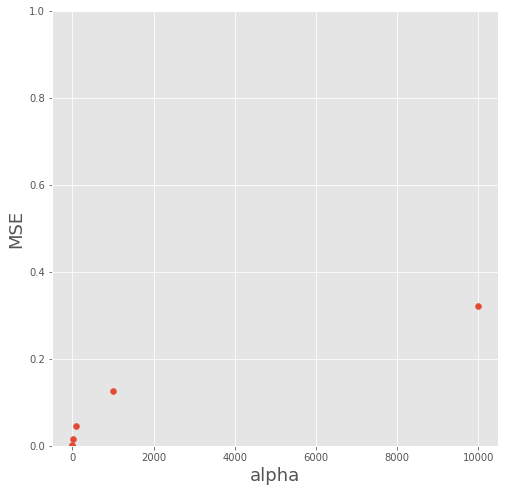

In [119]:
# Tips: - You can use log scale for alphas axis using [axis].set_xscale('log')
#      - Ensure 0 is shown in your MSE values axis using [axis].set_ylim(bottom=0)

#############################
#### YOUR CODE GOES HERE ####

mse_val_list = []
for metrics_tuple in dev_metrics_list:
  mse_val_list.append(metrics_tuple[0])

fig, axs = plt.subplots(figsize=(8,8))
# axs.set_xscale('log')
axs.set_ylim(bottom=0)
axs.scatter(alpha_list, mse_val_list)
plt.xlabel('alpha', fontsize=18)
plt.ylabel('MSE', fontsize=18)
plt.show()

#############################


**Question**

How did performance on training and dev sets change as $\alpha$ changed? What differences did you observe in the effect of regularization on the original vs expanded feature models? 

(Your answer here)

The MSE value of the original training and dev sets increase with larger intervals as the 𝛼 values, whereas that of the transformed training and dev sets increase but with much lower differences between alpha values. 

Regularization leads to a lower performance with the best model being that whose alpha value is 0 as this leads to a lower MSE value.

# Conclusion and next steps

Congratulations on completing the project! You built nonlinear regression models for per-customer revenue prediction. We can now deliver this model along with predictions to the customer success and sales teams to allow them to try and prioritize customer interactions based on model predictions. 

In this project, we also introduced several regression techniques, error metrics, hypothesis-driven development, and regularization. We will continue to use these core conepts throughout the course. 
